# Merging and Preprocessing

### Load Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import naive_bayes
from datetime import timedelta
import re
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVR
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import WordPunctTokenizer
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jason\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Player News

In [3]:
news = pd.read_excel('../data/news_data.xlsx')
news.head()

,date,headline,name,news,team
0,2017-12-10 10:40:00,Bucs DT Gerald McCoy fears he suffered a torn ...,Gerald McCoy,\n McCoy has torn his biceps twice...,Buccaneers
1,2017-12-10 09:28:00,Coach Todd Bowles announced Josh McCown suffer...,Josh McCown,\n McCown was banged up in this on...,Jets
2,2017-12-10 09:20:00,Keelan Cole caught all three of his targets fo...,Keelan Cole,\n Cole reeled in a 75-yard touchd...,Jaguars
3,2017-12-10 09:15:00,Dede Westbrook caught 5-of-8 targets for 81 ya...,Dede Westbrook,\n Westbrook's first NFL touchdown...,Jaguars
4,2017-12-10 09:10:00,Marqise Lee caught 5-of-6 targets for 65 yards...,Marqise Lee,\n Lee has turned into a solid flo...,Jaguars


In [4]:
news.tail()

,date,headline,name,news,team
22476,2016-10-20 09:31:00,"Ladarius Green (ankle, PUP) said there is ""no ...",Ladarius Green,"\n Signed to a four-year, $20 mill...",Free Agent
22477,2016-10-20 09:28:00,Gerald McCoy (calf) practiced on a limited bas...,Gerald McCoy,\n It is a step in the right direc...,Buccaneers
22478,2016-10-20 09:25:00,Jordan Reed said he hid the concussion he suff...,Jordan Reed,"\n ""I kind of kept it to myself,"" ...",Redskins
22479,2016-10-20 09:13:00,Colts coach Chuck Pagano said DE Henry Anderso...,Henry Anderson,\n Anderson played through his kne...,Colts
22480,2016-10-20 09:10:00,"With Doug Martin (hamstring) out, Jacquizz Rod...",Jacquizz Rodgers,\n Rodgers was the unquestioned wo...,Buccaneers


### Preprocessing Player News

In [5]:
cities = {
    'Bills':'Buffalo',
    'Dolphins':'Miami',
    'Patriots':'New England',
    'Jets':'New York',
    'Ravens':'Baltimore',
    'Bengals':'Cincinnati',
    'Browns':'Cleveland',
    'Steelers':'Pittsburgh',
    'Texans':'Houston',
    'Colts':'Indianapolis',
    'Jaguars':'Jacksonville',
    'Titans':'Tennessee',
    'Broncos':'Denver',
    'Chiefs':'Kansas City',
    'Chargers':'Los Angeles',
    'Raiders':'Oakland',
    'Cowboys':'Dallas',
    'Giants':'New York',
    'Eagles':'Philadelphia',
    'Redskins':'Washington',
    'Bears':'Chicago',
    'Lions':'Detroit',
    'Packers':'Green Bay',
    'Vikings':'Minnesota',
    'Falcons':'Atlanta',
    'Panthers':'Carolina',
    'Saints':'New Orleans',
    'Buccaneers':'Tampa Bay',
    'Cardinals':'Arizona',
    'Rams':'Los Angeles',
    '49ers':'San Francisco',
    'Seahawks':'Seattle'  
}

default_cities = defaultdict(str)
for city in cities.keys():
    default_cities[city] = cities[city]

In [6]:
regex = re.compile('[^a-zA-Z]')
to_display = ['name','news','news_clean','news_unigrams','news_bigrams']
stopWords = set(stopwords.words('english'))

def process_text(row):
    '''
    if the news mentions that player -> self
    if the news mentions the player's team -> ownteam
    if the news mentions the player's city -> owncity
    '''
    parsed_sentence = str()
    names = row['name'].split()
    for word in row['news'].split():
        word = regex.sub('',word)
        if word in names:
            parsed_sentence = parsed_sentence+'self '
        elif word ==row['team']:
            parsed_sentence = parsed_sentence+'ownteam '
        elif word in default_cities[row['team']].split():
            parsed_sentence = parsed_sentence+'owncity '
        elif word in stopWords:
            pass
        else:
            parsed_sentence = parsed_sentence+word+' '
    return parsed_sentence

def get_bigrams(myString):
    tokenizer = WordPunctTokenizer()
    tokens = tokenizer.tokenize(myString)
    #stemmer = PorterStemmer()
    bigram_finder = BigramCollocationFinder.from_words(tokens)
    bigram_tuples = bigram_finder.nbest(BigramAssocMeasures.chi_sq, 500)
    bigrams = []
    for bigram_tuple in bigram_tuples:
        x = "%s %s" % bigram_tuple
        bigrams.append(x)
        
    result = [' '.join([w.lower() for w in x.split()]) for x in bigrams]
    return result

def get_unigrams(myString):
    tokenizer = WordPunctTokenizer()
    tokens = tokenizer.tokenize(myString)
    #stemmer = PorterStemmer()
    result = [w.lower() for w in tokens if w.lower() not in stopWords]
    return result

news['news_clean'] = news.apply(process_text, axis = 1)
news['news_unigrams'] = news['news_clean'].apply(lambda x: get_unigrams(x))
news['news_bigrams'] = news['news_clean'].apply(lambda x: get_bigrams(x))
news['orig_unigrams'] = news['news'].apply(lambda x: get_unigrams(x))
news['orig_bigrams'] = news['news'].apply(lambda x: get_bigrams(x))
news[to_display].head()

,name,news,news_clean,news_unigrams,news_bigrams
0,Gerald McCoy,\n McCoy has torn his biceps twice...,self torn biceps twice already pro career tear...,"[self, torn, biceps, twice, already, pro, care...","[falcons panthers, he knows, panthers saints, ..."
1,Josh McCown,\n McCown was banged up in this on...,self banged one injuring back second quarter h...,"[self, banged, one, injuring, back, second, qu...","[bryce petty, hell undergo, its tough, mccowns..."
2,Keelan Cole,\n Cole reeled in a 75-yard touchd...,self reeled yard touchdown beautiful catch thr...,"[self, reeled, yard, touchdown, beautiful, cat...","[blake bortles, bortles give, it second, wr he..."
3,Dede Westbrook,\n Westbrook's first NFL touchdown...,Westbrooks first NFL touchdown came yard corne...,"[westbrooks, first, nfl, touchdown, came, yard...","[his eight, nfl touchdown, texans defense, cam..."
4,Marqise Lee,\n Lee has turned into a solid flo...,self turned solid floor play fantasy five catc...,"[self, turned, solid, floor, play, fantasy, fi...","[after catching, wr option, week meeting, with..."


### Player Scores and Averages

In [7]:
#Match up scores with articles
scores = pd.read_csv('../data/fantasy_points_data.csv', parse_dates= True)
scores.head()

,Player,Team,Position,Year,Week,Points
0,Drew Brees,NO,QB,2016,1,37.7
1,Andrew Luck,IND,QB,2016,1,37.4
2,Alex Smith,KC,QB,2016,1,33.7
3,Jameis Winston,TB,QB,2016,1,30.4
4,Matthew Stafford,DET,QB,2016,1,29.5


In [8]:
def yearly_average(row):
    if row['Year']==2016:
        return row['Points']/weeks_in_2016
    elif row['Year']==2017:
        return row['Points']/weeks_in_2017

In [9]:
#Computing average over all weeks in year
weeks_in_2016 = scores[scores.Year==2016]['Week'].max()
weeks_in_2017 = scores[scores.Year==2017]['Week'].max()
avg_scores = scores.groupby(['Player','Year'], as_index=False)['Points'].sum()
avg_scores['Avg_Points']= avg_scores.apply(yearly_average,axis=1)
avg_scores.columns = ['Player', 'Year', 'SeasonPoints', 'AvgSeasonPoints']

In [10]:
#computing average points from all previous weeks played
years = scores.Year.unique()
players = scores.Player.unique()
weeks = scores.Week.unique()

cols = ['Player','Week','Year','Prev_Avg_Points']
data = []

for year in years:
    for player in players:
        for week in weeks:    
            df = scores[(scores['Player'] == player) & (scores['Year'] == year) &(scores['Week']<week)]
            avg_points = df['Points'].mean()
            vals = [player,week,year,avg_points]
            data.append(dict(zip(cols,vals)))
results = pd.DataFrame(data)
results.head()

,Player,Prev_Avg_Points,Week,Year
0,Drew Brees,NaN,1,2016
1,Drew Brees,37.700000,2,2016
2,Drew Brees,26.100000,3,2016
3,Drew Brees,26.033333,4,2016
4,Drew Brees,22.475000,5,2016


In [11]:
#Computing averages over all weeks *played* in a year
wkavg_scores = scores.groupby(['Player', 'Year'], as_index=False)['Points'].mean()
wkavg_scores.columns = ['Player', 'Year', 'AvgWkPoints']
wkavg_scores.head()

,Player,Year,AvgWkPoints
0,A.J. Derby,2016,3.425000
1,A.J. Derby,2017,4.050000
2,A.J. Green,2016,13.377778
3,A.J. Green,2017,10.692308
4,AJ McCarron,2017,1.900000


In [12]:
scores_combined = scores.merge(avg_scores, 
                               how='inner', 
                               on=['Player','Year'])
scores_combined = scores_combined.merge(wkavg_scores,
                                  how='inner',
                                  on=['Player', 'Year'])
scores_combined = scores_combined.merge(results,
                                  how='inner',
                                  on=['Player', 'Year','Week'])
scores_combined['Diff_from_Avg'] = scores_combined['Points'] - scores_combined['AvgSeasonPoints']
scores_combined['Diff_from_WkAvg'] = scores_combined['Points'] - scores_combined['AvgWkPoints']
scores_combined['Diff_from_PrevWkAvg'] = scores_combined['Points'] - scores_combined['Prev_Avg_Points'] 
scores_combined.head()

,Player,Team,Position,Year,Week,Points,SeasonPoints,AvgSeasonPoints,AvgWkPoints,Prev_Avg_Points,Diff_from_Avg,Diff_from_WkAvg,Diff_from_PrevWkAvg
0,Drew Brees,NO,QB,2016,1,37.7,338.5,19.911765,21.15625,NaN,17.788235,16.54375,NaN
1,Drew Brees,NO,QB,2016,2,14.5,338.5,19.911765,21.15625,37.700000,-5.411765,-6.65625,-23.200000
2,Drew Brees,NO,QB,2016,3,25.9,338.5,19.911765,21.15625,26.100000,5.988235,4.74375,-0.200000
3,Drew Brees,NO,QB,2016,4,11.8,338.5,19.911765,21.15625,26.033333,-8.111765,-9.35625,-14.233333
4,Drew Brees,NO,QB,2016,6,32.6,338.5,19.911765,21.15625,22.475000,12.688235,11.44375,10.125000


### Player predicted scores

In [77]:
#Pull in predicted scores
preds2016 = pd.read_csv('../data/full_2016_projections.csv', parse_dates= True)
preds2017 = pd.read_csv('../data/full_2017_projections.csv', parse_dates = True)
preds2016['Year'] = 2016
preds2017['Year'] = 2017
preds = pd.concat([preds2016, preds2017])

In [78]:
preds.head()

,Player,Pos,Week,Team,Opp,Pass Yds,TD,Int,Rush Yds,TD.1,Rec,Yds,TD.2,Fantasy Points,Year
0,David Johnson,RB,10,ARI,SF,0.0,0.0,0.0,112.4,1.1,4.2,40.8,0.3,27.52,2016
1,Cam Newton,QB,2,CAR,SF,243.5,1.8,0.6,41.6,0.6,0.0,0.0,0.0,23.10,2016
2,Aaron Rodgers,QB,9,GB,IND,295.6,2.2,0.8,20.4,0.4,0.0,0.0,0.0,22.86,2016
3,Matt Ryan,QB,9,ATL,TB,323.1,2.6,0.8,9.3,0.1,0.0,0.0,0.0,22.65,2016
4,Cam Newton,QB,4,CAR,ATL,243.9,1.8,0.8,41.4,0.6,0.0,0.0,0.0,22.50,2016


In [79]:
#Restructuring predicted points to mirror actual score data
preds = preds[['Player', 'Team', 'Pos', 'Year', 'Week', 'Fantasy Points']]
preds.columns = ['Player', 'Team', 'Position', 'Year', 'Week', 'Points']

In [80]:
#Replacing scores with predicted scores
scores = preds.copy(deep=True)

In [81]:
#Computing average over all weeks in year
weeks_in_2016 = scores[scores.Year==2016]['Week'].max()
weeks_in_2017 = scores[scores.Year==2017]['Week'].max()
avg_scores = scores.groupby(['Player','Year'], as_index=False)['Points'].sum()
avg_scores['Avg_Points']= avg_scores.apply(yearly_average,axis=1)
avg_scores.columns = ['Player', 'Year', 'SeasonPoints', 'AvgSeasonPoints']

In [82]:
#Computing averages over all weeks *played* in a year
wkavg_scores = scores.groupby(['Player', 'Year'], as_index=False)['Points'].mean()
wkavg_scores.columns = ['Player', 'Year', 'AvgWkPoints']
wkavg_scores.head()

,Player,Year,AvgWkPoints
0,AJ Green,2016,19.012000
1,AJ Green,2017,16.262143
2,Aaron Jones,2017,9.964000
3,Aaron Rodgers,2016,19.733333
4,Aaron Rodgers,2017,19.687143


In [83]:
scores_combined = scores.merge(avg_scores, 
                               how='inner', 
                               on=['Player','Year'])
scores_combined = scores_combined.merge(wkavg_scores,
                                  how='inner',
                                  on=['Player', 'Year'])
scores_combined['Diff_from_Avg'] = scores_combined['Points'] - scores_combined['AvgSeasonPoints']
scores_combined['Diff_from_WkAvg'] = scores_combined['Points'] - scores_combined['AvgWkPoints'] 
scores_combined.head()

,Player,Team,Position,Year,Week,Points,SeasonPoints,AvgSeasonPoints,AvgWkPoints,Diff_from_Avg,Diff_from_WkAvg
0,David Johnson,ARI,RB,2016,10,27.52,323.05,20.190625,21.536667,7.329375,5.983333
1,David Johnson,ARI,RB,2016,13,25.62,323.05,20.190625,21.536667,5.429375,4.083333
2,David Johnson,ARI,RB,2016,14,25.23,323.05,20.190625,21.536667,5.039375,3.693333
3,David Johnson,ARI,RB,2016,15,25.78,323.05,20.190625,21.536667,5.589375,4.243333
4,David Johnson,ARI,RB,2016,12,24.09,323.05,20.190625,21.536667,3.899375,2.553333


### Merging

In [13]:
start_of_season = {2016:pd.datetime.strptime('2016-09-08', '%Y-%m-%d'),
                  2017:pd.datetime.strptime('2017-09-08', '%Y-%m-%d')}

In [14]:
#Add in the first and last date for a given playing week
scores_combined['max_date'] = scores_combined.apply(lambda x: start_of_season[x['Year']] + timedelta(weeks = x['Week']), axis=1)
scores_combined['min_date'] = scores_combined.apply(lambda x: start_of_season[x['Year']] + timedelta(weeks = x['Week'] - 1), axis=1)

In [15]:
scores_combined.dtypes

Player                         object
Team                           object
Position                       object
Year                            int64
Week                            int64
Points                        float64
SeasonPoints                  float64
AvgSeasonPoints               float64
AvgWkPoints                   float64
Prev_Avg_Points               float64
Diff_from_Avg                 float64
Diff_from_WkAvg               float64
Diff_from_PrevWkAvg           float64
max_date               datetime64[ns]
min_date               datetime64[ns]
dtype: object

In [16]:
news.dtypes

date             datetime64[ns]
headline                 object
name                     object
news                     object
team                     object
news_clean               object
news_unigrams            object
news_bigrams             object
orig_unigrams            object
orig_bigrams             object
dtype: object

In [17]:
#Scores data does not use . in names (i.e. 'C.J. Anderson')
news['name'] = news['name'].apply(lambda x: x.replace('.', ''))

In [18]:
#Merge news with scores and filter out scores that are not within a playing week
combined = scores_combined.merge(news, how='inner', left_on='Player', right_on='name')
combined = combined[(combined['date'] <= combined['max_date']) & 
                    (combined['date'] >= combined['min_date'])]

In [19]:
combined.shape

(10787, 25)

In [20]:
mismatched_scores = scores_combined.merge(news, how='left', left_on='Player', right_on='name')
mismatched_scores = mismatched_scores[(mismatched_scores['date'] <= mismatched_scores['max_date']) 
                                      & (mismatched_scores['date'] >= mismatched_scores['min_date']) 
                                      & (mismatched_scores['name'].isnull())]
                                     #]
mismatched_news = scores_combined.merge(news, how='right', left_on='Player', right_on='name')
mismatched_news = mismatched_news[mismatched_news['SeasonPoints'].isnull()]

In [21]:
#Number of players with no scores
len(news[np.invert(np.in1d(news.name, scores_combined.Player))].name.value_counts())

1403

In [22]:
#Count of news articles with no scores
np.sum(news[np.invert(np.in1d(news.name, scores_combined.Player))].name.value_counts())

6872

In [23]:
news[np.invert(np.in1d(news.name, scores_combined.Player))].name.value_counts()

Odell Beckham         88
CJ Prosise            85
TY Hilton             73
AJ Green              67
Luke Kuechly          49
TJ Yeldon             49
JJ Nelson             47
CJ Fiedorowicz        44
Steve Smith Sr        43
CJ Anderson           40
Tyron Smith           40
John Ross             39
Vontae Davis          39
Ryan Kalil            37
Terron Armstead       35
Ted Ginn              33
Darrelle Revis        32
Jimmy Smith           32
Cordy Glenn           29
Trent Williams        29
David Amerson         28
Joe Haden             28
Muhammad Wilkerson    28
Justin Houston        28
Dont'a Hightower      27
Teddy Bridgewater     27
Mike Pouncey          27
Tyrann Mathieu        27
Michael Bennett       27
Ezekiel Ansah         26
                      ..
Byron Bell             1
Don Jones              1
Donte Deayon           1
Quinton Dial           1
DaQuan Jones           1
Vinny Curry            1
Hau'oli Kikaha         1
Charles James          1
Jordan Phillips        1


In [24]:
mismatched_scores.head()

,Player,Team,Position,Year,Week,Points,SeasonPoints,AvgSeasonPoints,AvgWkPoints,Prev_Avg_Points,...,date,headline,name,news,team,news_clean,news_unigrams,news_bigrams,orig_unigrams,orig_bigrams


### Output

In [25]:
#combined.to_csv('../data/news_and_scores.csv', index=False)
#combined.to_excel('../data/news_and_scores_no_stemmer.xlsx', index=False)
combined.to_csv('../data/news_and_scores_no_stemmer.csv', index=False)

In [97]:
mismatched_scores.to_csv('../data/mismatched_scores.csv', index=False)
mismatched_news.to_csv('../data/mismatched_news.csv', index=False)

In [98]:
mismatched_scores.shape

(0, 23)

In [99]:
mismatched_news.shape

(8738, 23)

# Modeling

In [1]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
from sklearn import naive_bayes
from sklearn.model_selection import train_test_split
from ast import literal_eval
from scipy.sparse import csr_matrix
from sklearn.svm import LinearSVR
from sklearn.model_selection import GridSearchCV

In [79]:
data = combined.copy(deep=True)
data = data[np.isfinite(data['Diff_from_PrevWkAvg'])]

In [80]:
class Vocabulary(object):
    START_TOKEN = "<s>"
    END_TOKEN = "</s>"
    UNK_TOKEN = "<unk>"

    def __init__(self, tokens, size=None):
        self.unigram_counts = collections.Counter(tokens)
        self.num_unigrams = sum(self.unigram_counts.values())
        # leave space for "<s>", "</s>", and "<unk>"
        top_counts = self.unigram_counts.most_common(None if size is None else (size - 3))
        vocab = ([self.START_TOKEN, self.END_TOKEN, self.UNK_TOKEN] +
                 [w for w,c in top_counts])

        # Assign an id to each word, by frequency
        self.id_to_word = dict(enumerate(vocab))
        self.word_to_id = {v:k for k,v in self.id_to_word.items()}
        self.size = len(self.id_to_word)
        if size is not None:
            assert(self.size <= size)

        # For convenience
        self.wordset = set(self.word_to_id.keys())

        # Store special IDs
        self.START_ID = self.word_to_id[self.START_TOKEN]
        self.END_ID = self.word_to_id[self.END_TOKEN]
        self.UNK_ID = self.word_to_id[self.UNK_TOKEN]

    def words_to_ids(self, words):
        return [self.word_to_id.get(w, self.UNK_ID) for w in words]

    def ids_to_words(self, ids):
        return [self.id_to_word[i] for i in ids]

    def sentence_to_ids(self, words):
        return [self.START_ID] + self.words_to_ids(words) + [self.END_ID]

    def ordered_words(self):
        """Return a list of words, ordered by id."""
        return self.ids_to_words(range(self.size))

In [81]:
#tokenize
token_feed_unigram = (word for news in data['news_unigrams'] for word in news)
token_feed_bigram = (word for news in data['news_bigrams'] for word in news)
vocab_unigram = Vocabulary(token_feed_unigram)
vocab_bigram = Vocabulary(token_feed_bigram)

token_feed_unigram_orig = (word for news in data['orig_unigrams'] for word in news)
token_feed_bigram_orig = (word for news in data['orig_bigrams'] for word in news)
vocab_unigram_orig = Vocabulary(token_feed_unigram_orig)
vocab_bigram_orig = Vocabulary(token_feed_bigram_orig)

In [82]:
#encoding
encoded_unigram = [collections.Counter(vocab_unigram.words_to_ids(x)) for x in data['news_unigrams']]
encoded_bigram = [collections.Counter(vocab_bigram.words_to_ids(x)) for x in data['news_bigrams']]
encoded_unigram_orig = [collections.Counter(vocab_unigram_orig.words_to_ids(x)) for x in data['orig_unigrams']]
encoded_bigram_orig = [collections.Counter(vocab_bigram_orig.words_to_ids(x)) for x in data['orig_bigrams']]

In [38]:
data.head()

,Player,Team,Position,Year,Week,Points,SeasonPoints,AvgSeasonPoints,AvgWkPoints,Prev_Avg_Points,...,date,headline,name,news,team,news_clean,news_unigrams,news_bigrams,orig_unigrams,orig_bigrams
20,Drew Brees,NO,QB,2016,1,37.7,338.5,19.911765,21.15625,NaN,...,2016-09-11 04:33:00,Drew Brees completed 28-of-42 passes for 424 y...,Drew Brees,\n Aside from an early lost fumble...,Saints,Aside early lost fumble self played quarterbac...,"[aside, early, lost, fumble, self, played, qua...","[aside early, the highlight, bumbling defense,...","[aside, early, lost, fumble, ,, brees, played,...","[, brees, . the, aside from, brees played, the..."
21,Drew Brees,NO,QB,2016,1,37.7,338.5,19.911765,21.15625,NaN,...,2016-09-08 11:56:00,Drew Brees got a $30 million signing bonus on ...,Drew Brees,\n That bonus will be spread out a...,Saints,That bonus spread across next five years ownte...,"[bonus, spread, across, next, five, years, own...","[that bonus, the entire, across next, base sal...","[bonus, spread, across, next, five, years, sai...","[, lowering, that bonus, the entire, a $, base..."
57,Drew Brees,NO,QB,2016,2,14.5,338.5,19.911765,21.15625,37.700000,...,2016-09-18 05:32:00,Drew Brees completed 29-of-44 passes for 263 y...,Drew Brees,\n Brees got off to a very slow st...,Saints,self got slow start averaging five yards per a...,"[self, got, slow, start, averaging, five, yard...","[atlanta next, giants put, he didnt, it quiet,...","[brees, got, slow, start, ,, averaging, five, ...","[3 at, atlanta next, giants put, he didn, it w..."
94,Drew Brees,NO,QB,2016,3,25.9,338.5,19.911765,21.15625,26.100000,...,2016-09-27 12:01:00,Drew Brees completed 36-of-54 passes for 376 y...,Drew Brees,"\n Unfortunately for the Saints, t...",Saints,Unfortunately ownteam defense couldnt stop Fal...,"[unfortunately, ownteam, defense, couldnt, sto...","[coby fleener, diego week, fleener two, ingram...","[unfortunately, saints, ,, defense, ', stop, f...","[305 pass, coby fleener, mark ingram, michael ..."
131,Drew Brees,NO,QB,2016,4,11.8,338.5,19.911765,21.15625,26.033333,...,2016-10-02 08:25:00,Drew Brees completed 23-of-36 passes for 206 y...,Drew Brees,\n It was not a vintage performanc...,Saints,It vintage performance self He struggled accur...,"[vintage, performance, self, struggled, accura...","[chargers gifted, it vintage, panthers home, q...","[vintage, performance, brees, ., struggled, ac...","[072 yards, 40 touchdowns, chargers gifted, it..."


In [119]:
#Sparse matrix
#Processed Unigram
row = []
col = []
val = []
for x, count in enumerate(encoded_unigram):
    for y, z in count.items():
        row.append(x)
        col.append(y)
        val.append(z)
row = np.array(row)
col = np.array(col)
val = np.array(val)
encoded_unigram_sparse = csr_matrix((val, (row, col)), shape=(len(encoded_unigram), vocab_unigram.size))
#Processed Bigram
row = []
col = []
val = []
for x, count in enumerate(encoded_bigram):
    for y, z in count.items():
        row.append(x)
        col.append(y)
        val.append(z)
row = np.array(row)
col = np.array(col)
val = np.array(val)
encoded_bigram_sparse = csr_matrix((val, (row, col)), shape=(len(encoded_bigram), vocab_bigram.size))

#Original Unigram
row = []
col = []
val = []
for x, count in enumerate(encoded_unigram_orig):
    for y, z in count.items():
        row.append(x)
        col.append(y)
        val.append(z)
row = np.array(row)
col = np.array(col)
val = np.array(val)
encoded_unigram_orig_sparse = csr_matrix((val, (row, col)), shape=(len(encoded_unigram_orig), vocab_unigram_orig.size))

#Original Bigram
row = []
col = []
val = []
for x, count in enumerate(encoded_bigram_orig):
    for y, z in count.items():
        row.append(x)
        col.append(y)
        val.append(z)
row = np.array(row)
col = np.array(col)
val = np.array(val)
encoded_bigram_orig_sparse = csr_matrix((val, (row, col)), shape=(len(encoded_bigram_orig), vocab_bigram_orig.size))

In [120]:
#Unigram Counts No preprocessing
SVM = LinearSVR()
params = {'C': [5e3],
        'epsilon': [0.01], }
grid = GridSearchCV(SVM, params, cv=5, scoring='mean_squared_error')
grid.fit(encoded_unigram_orig_sparse, data['Diff_from_PrevWkAvg'])

C:\Users\Jason\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Jason\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Jason\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Jason\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Jason\Anaconda3\lib\sit

GridSearchCV(cv=5, error_score='raise',
       estimator=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [5000.0], 'epsilon': [0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='mean_squared_error', verbose=0)

In [121]:
#Bigram Counts No Preprocessing
SVM = LinearSVR()
params = {'C': [5e3],
        'epsilon': [0.01]}
grid2 = GridSearchCV(SVM, params, cv=5, scoring='mean_squared_error')
grid2.fit(encoded_bigram_orig_sparse, data['Diff_from_PrevWkAvg'])

C:\Users\Jason\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Jason\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Jason\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Jason\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Jason\Anaconda3\lib\sit

GridSearchCV(cv=5, error_score='raise',
       estimator=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [5000.0], 'epsilon': [0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='mean_squared_error', verbose=0)

In [122]:
#Unigram Counts With preprocessing
SVM = LinearSVR()
params = {'C': [5e3],
        'epsilon': [0.01]}
grid3 = GridSearchCV(SVM, params, cv=5, scoring='mean_squared_error')
grid3.fit(encoded_unigram_sparse, data['Diff_from_PrevWkAvg'])

C:\Users\Jason\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Jason\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Jason\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Jason\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Jason\Anaconda3\lib\sit

GridSearchCV(cv=5, error_score='raise',
       estimator=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [5000.0], 'epsilon': [0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='mean_squared_error', verbose=0)

In [123]:
#Bigram Counts With Preprocessing
SVM = LinearSVR()
params = {'C': [5e3],
        'epsilon': [0.01]}
grid4 = GridSearchCV(SVM, params, cv=5, scoring='mean_squared_error')
grid4.fit(encoded_bigram_sparse, data['Diff_from_PrevWkAvg'])

C:\Users\Jason\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Jason\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Jason\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Jason\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Jason\Anaconda3\lib\sit

GridSearchCV(cv=5, error_score='raise',
       estimator=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [5000.0], 'epsilon': [0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='mean_squared_error', verbose=0)

In [124]:
#Reencode all for presence instead of counts
#Processed Unigram
row = []
col = []
val = []
for x, count in enumerate(encoded_unigram):
    for y, z in count.items():
        row.append(x)
        col.append(y)
        val.append(1)
row = np.array(row)
col = np.array(col)
val = np.array(val)
encoded_unigram_sparse = csr_matrix((val, (row, col)), shape=(len(encoded_unigram), vocab_unigram.size))
#Processed Bigram
row = []
col = []
val = []
for x, count in enumerate(encoded_bigram):
    for y, z in count.items():
        row.append(x)
        col.append(y)
        val.append(1)
row = np.array(row)
col = np.array(col)
val = np.array(val)
encoded_bigram_sparse = csr_matrix((val, (row, col)), shape=(len(encoded_bigram), vocab_bigram.size))

#Original Unigram
row = []
col = []
val = []
for x, count in enumerate(encoded_unigram_orig):
    for y, z in count.items():
        row.append(x)
        col.append(y)
        val.append(1)
row = np.array(row)
col = np.array(col)
val = np.array(val)
encoded_unigram_orig_sparse = csr_matrix((val, (row, col)), shape=(len(encoded_unigram_orig), vocab_unigram_orig.size))

#Original Bigram
row = []
col = []
val = []
for x, count in enumerate(encoded_bigram_orig):
    for y, z in count.items():
        row.append(x)
        col.append(y)
        val.append(1)
row = np.array(row)
col = np.array(col)
val = np.array(val)
encoded_bigram_orig_sparse = csr_matrix((val, (row, col)), shape=(len(encoded_bigram_orig), vocab_bigram_orig.size))

In [125]:
#Unigram Presence No preprocessing
SVM = LinearSVR()
params = {'C': [5e3],
        'epsilon': [0.01]}
grid5 = GridSearchCV(SVM, params, cv=5, scoring='mean_squared_error')
grid5.fit(encoded_unigram_orig_sparse, data['Diff_from_PrevWkAvg'])

C:\Users\Jason\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Jason\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Jason\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Jason\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Jason\Anaconda3\lib\sit

GridSearchCV(cv=5, error_score='raise',
       estimator=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [5000.0], 'epsilon': [0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='mean_squared_error', verbose=0)

In [126]:
#Bigram Presence No Preprocessing
SVM = LinearSVR()
params = {'C': [5e3],
        'epsilon': [0.01]}
grid6 = GridSearchCV(SVM, params, cv=5, scoring='mean_squared_error')
grid6.fit(encoded_bigram_orig_sparse, data['Diff_from_PrevWkAvg'])

C:\Users\Jason\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Jason\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Jason\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Jason\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Jason\Anaconda3\lib\sit

GridSearchCV(cv=5, error_score='raise',
       estimator=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [5000.0], 'epsilon': [0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='mean_squared_error', verbose=0)

In [127]:
#Unigram Presence With preprocessing
SVM = LinearSVR()
params = {'C': [5e3],
        'epsilon': [0.01]}
grid7 = GridSearchCV(SVM, params, cv=5, scoring='mean_squared_error')
grid7.fit(encoded_unigram_sparse, data['Diff_from_PrevWkAvg'])

C:\Users\Jason\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Jason\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Jason\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Jason\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Jason\Anaconda3\lib\sit

GridSearchCV(cv=5, error_score='raise',
       estimator=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [5000.0], 'epsilon': [0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='mean_squared_error', verbose=0)

In [128]:
#Bigram Presence With Preprocessing
SVM = LinearSVR()
params = {'C': [5e3],
        'epsilon': [0.01]}
grid8 = GridSearchCV(SVM, params, cv=5, scoring='mean_squared_error')
grid8.fit(encoded_bigram_sparse, data['Diff_from_PrevWkAvg'])

C:\Users\Jason\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Jason\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Jason\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Jason\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Jason\Anaconda3\lib\sit

GridSearchCV(cv=5, error_score='raise',
       estimator=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [5000.0], 'epsilon': [0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='mean_squared_error', verbose=0)

In [129]:
np.mean(np.square(grid.predict(encoded_unigram_orig_sparse) - np.array(data['Diff_from_PrevWkAvg'], dtype=np.float32)))**.5

4.0448141996443487

In [130]:
np.mean(np.square(grid2.predict(encoded_bigram_orig_sparse) - np.array(data['Diff_from_PrevWkAvg'], dtype=np.float32)))**.5

0.39564048476609293

In [131]:
np.mean(np.square(grid3.predict(encoded_unigram_sparse) - np.array(data['Diff_from_PrevWkAvg'], dtype=np.float32)))**.5

3.8458563820032508

In [132]:
np.mean(np.square(grid4.predict(encoded_bigram_sparse) - np.array(data['Diff_from_PrevWkAvg'], dtype=np.float32)))**.5

0.35647733294362477

In [133]:
np.mean(np.square(grid5.predict(encoded_unigram_orig_sparse) - np.array(data['Diff_from_PrevWkAvg'], dtype=np.float32)))**.5

3.536393020582369

In [134]:
np.mean(np.square(grid6.predict(encoded_bigram_orig_sparse) - np.array(data['Diff_from_PrevWkAvg'], dtype=np.float32)))**.5

0.33761935939590881

In [135]:
np.mean(np.square(grid7.predict(encoded_unigram_sparse) - np.array(data['Diff_from_PrevWkAvg'], dtype=np.float32)))**.5

2.7945029183885852

In [136]:
np.mean(np.square(grid8.predict(encoded_bigram_sparse) - np.array(data['Diff_from_PrevWkAvg'], dtype=np.float32)))**.5

0.39535735775451886

In [137]:
grid.best_score_

-381.3353041437245

In [107]:
grid.best_params_

{'C': 5000.0, 'epsilon': 0.01}

In [108]:
grid2.best_params_

{'C': 50000.0, 'epsilon': 0.005}

In [109]:
grid3.best_params_

{'C': 10000.0, 'epsilon': 0.01}

In [110]:
grid4.best_params_

{'C': 5000.0, 'epsilon': 0.005}

In [111]:
grid5.best_params_

{'C': 5000.0, 'epsilon': 0.01}

In [112]:
grid6.best_params_

{'C': 50000.0, 'epsilon': 0.005}

In [113]:
grid7.best_params_

{'C': 50000.0, 'epsilon': 0.01}

In [114]:
grid8.best_params_

{'C': 50000.0, 'epsilon': 0.0005}

In [44]:
def plot_coefficients(classifier, feature_names, top_features=10):
    coef = classifier.best_estimator_.coef_.ravel()
    #coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    #feature_names = feature_names)
    #return feature_names(top_coefficients)
    plt.xticks(np.arange(0, 2 * top_features), feature_names(top_coefficients), rotation=60, ha='right')
    plt.show()

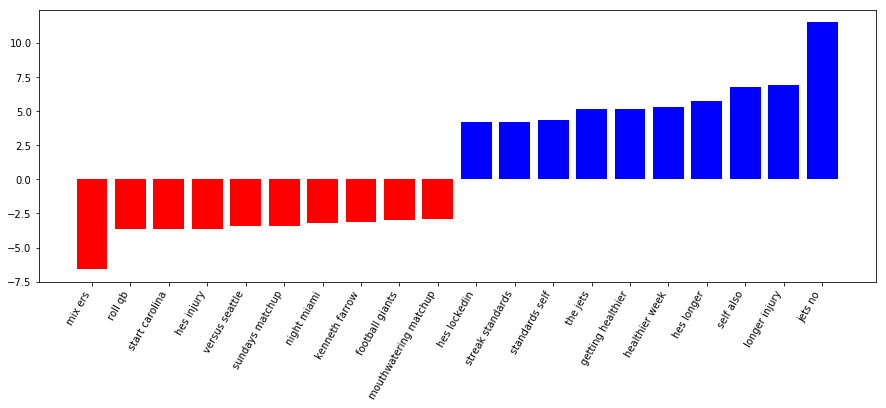

In [61]:
plot_coefficients(grid8, vocab_bigram.ids_to_words)

In [62]:
np.sum(np.square(np.array(data['Diff_from_WkAvg'], dtype=np.float32)))**.5

587.81462320190712